In [ ]:
import os
import gc
import numpy as np
import pandas as pd

# ---------- Paths ----------
DATA_DIR = os.path.join("home-credit-default-risk")  # relative path from your notebook

# ---------- Utility: safer aggregation column names ----------
def flatten_columns(df, prefix=""):
    """Flatten a MultiIndex column after groupby-agg and add an optional prefix."""
    df.columns = [
        f"{prefix}{c[0]}_{c[1]}" if isinstance(c, tuple) else f"{prefix}{c}"
        for c in df.columns
    ]
    return df

# ---------- Utility: light memory reduction ----------
def reduce_memory_usage(df):
    """
    Downcast numeric columns to reduce RAM usage.
    Be careful: keep floats as float32 and ints as smallest possible.
    """
    for col in df.columns:
        col_type = df[col].dtype

        if pd.api.types.is_integer_dtype(col_type):
            df[col] = pd.to_numeric(df[col], downcast="integer")
        elif pd.api.types.is_float_dtype(col_type):
            df[col] = pd.to_numeric(df[col], downcast="float")
        # Leave object/categorical as-is here
    return df

# ---------- Step 1: Load main tables ----------
app_train = pd.read_csv(os.path.join(DATA_DIR, "application_train.csv"))
app_test  = pd.read_csv(os.path.join(DATA_DIR, "application_test.csv"))

print("Train shape:", app_train.shape, " Test shape:", app_test.shape)

# Keep only SK_ID_CURR and TARGET for safety (optional)
# We'll merge features back onto this frame.
train_base = app_train.copy()

# ---------- Step 2: bureau_balance -> bureau -> application ----------
# Load child first
bb = pd.read_csv(os.path.join(DATA_DIR, "bureau_balance.csv"))
# Aggregate at SK_ID_BUREAU level
bb_agg = bb.groupby("SK_ID_BUREAU").agg({
    "MONTHS_BALANCE": ["min", "max", "mean"],
    "STATUS": "nunique"
})
bb_agg = flatten_columns(bb_agg, prefix="BB_")
bb_agg.reset_index(inplace=True)
del bb; gc.collect()

# Load bureau and merge bb_agg onto it
bureau = pd.read_csv(os.path.join(DATA_DIR, "bureau.csv"))
bureau = bureau.merge(bb_agg, on="SK_ID_BUREAU", how="left")
del bb_agg; gc.collect()

# Aggregate bureau at SK_ID_CURR level (choose a few robust stats)
bureau_agg = bureau.groupby("SK_ID_CURR").agg({
    "SK_ID_BUREAU": "count",
    "AMT_CREDIT_SUM": ["mean", "max", "sum"],
    "AMT_CREDIT_SUM_DEBT": ["mean", "sum"],
    "CREDIT_DAY_OVERDUE": ["max", "mean"],
    "BB_MONTHS_BALANCE_min": "min",
    "BB_MONTHS_BALANCE_max": "max",
    "BB_MONTHS_BALANCE_mean": "mean",
    "BB_STATUS_nunique": "mean",
})
bureau_agg = flatten_columns(bureau_agg, prefix="BUREAU_")
bureau_agg.reset_index(inplace=True)

# Optional memory reduction
bureau_agg = reduce_memory_usage(bureau_agg)

# Merge onto train_base
train_base = train_base.merge(bureau_agg, on="SK_ID_CURR", how="left")
print("After bureau merge:", train_base.shape)

del bureau, bureau_agg; gc.collect()

# ---------- Step 3: POS/INST/CC -> previous_application -> application ----------
def aggregate_child_by_prev(filename, prefix):
    """
    Read a monthly/transactional child table keyed by SK_ID_PREV,
    aggregate to SK_ID_PREV level, and return the aggregated frame.
    """
    path = os.path.join(DATA_DIR, filename)
    df = pd.read_csv(path)
    # Select only numeric columns for aggregation
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Remove the key itself if present in num_cols
    if "SK_ID_PREV" in num_cols:
        num_cols.remove("SK_ID_PREV")
    agg = df.groupby("SK_ID_PREV")[num_cols].agg(["mean", "max", "min"])
    agg = flatten_columns(agg, prefix=f"{prefix}_")
    agg.reset_index(inplace=True)
    agg = reduce_memory_usage(agg)
    del df; gc.collect()
    return agg

# Load previous_application
prev = pd.read_csv(os.path.join(DATA_DIR, "previous_application.csv"))

# Aggregate children linked by SK_ID_PREV
pos_agg  = aggregate_child_by_prev("POS_CASH_balance.csv",      "POS")
inst_agg = aggregate_child_by_prev("installments_payments.csv", "INST")
cc_agg   = aggregate_child_by_prev("credit_card_balance.csv",   "CC")

# Merge child aggregates back to previous_application
prev = prev.merge(pos_agg,  on="SK_ID_PREV", how="left")
prev = prev.merge(inst_agg, on="SK_ID_PREV", how="left")
prev = prev.merge(cc_agg,   on="SK_ID_PREV", how="left")
del pos_agg, inst_agg, cc_agg; gc.collect()

# Aggregate previous_application at SK_ID_CURR level
# (choose a conservative set to avoid feature explosion)
num_cols_prev = prev.select_dtypes(include=[np.number]).columns.tolist()
if "SK_ID_CURR" not in num_cols_prev:
    num_cols_prev.append("SK_ID_CURR")
prev_agg = prev.groupby("SK_ID_CURR")[list(set(num_cols_prev) - {"SK_ID_CURR"})].agg(["mean","max","min"])
prev_agg = flatten_columns(prev_agg, prefix="PREV_")
prev_agg.reset_index(inplace=True)
prev_agg = reduce_memory_usage(prev_agg)

# Merge onto train_base
train_base = train_base.merge(prev_agg, on="SK_ID_CURR", how="left")
print("After previous_application merge:", train_base.shape)

del prev, prev_agg; gc.collect()

# ---------- Step 4: basic cleaning ----------
# simple missing fill for purely numeric columns (keep it light here)
num_cols = train_base.select_dtypes(include=[np.number]).columns
# Example: fill with median to keep robustness
# train_base[num_cols] = train_base[num_cols].fillna(train_base[num_cols].median())

# Reduce memory further
train_base = reduce_memory_usage(train_base)

# ---------- Step 5: Save ----------
train_base.to_csv("train_merged.csv", index=False)
print("Saved -> train_merged.csv | Final shape:", train_base.shape)

Train shape: (307511, 122)  Test shape: (48744, 121)
After bureau merge: (307511, 134)


C:\Users\USER\AppData\Local\Temp\ipykernel_31172\1426993704.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prev_agg.reset_index(inplace=True)


After previous_application merge: (307511, 500)
Saved -> train_merged.csv | Final shape: (307511, 500)


In [4]:
train_base.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PREV_DAYS_FIRST_DUE_min,PREV_INST_NUM_INSTALMENT_NUMBER_min_mean,PREV_INST_NUM_INSTALMENT_NUMBER_min_max,PREV_INST_NUM_INSTALMENT_NUMBER_min_min,PREV_INST_NUM_INSTALMENT_NUMBER_max_mean,PREV_INST_NUM_INSTALMENT_NUMBER_max_max,PREV_INST_NUM_INSTALMENT_NUMBER_max_min,PREV_POS_CNT_INSTALMENT_FUTURE_mean_mean,PREV_POS_CNT_INSTALMENT_FUTURE_mean_max,PREV_POS_CNT_INSTALMENT_FUTURE_mean_min
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-565.0,1.0,1.0,1.0,19.000000,19.0,19.0,15.000000,15.000,15.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-2310.0,1.0,1.0,1.0,8.333333,12.0,6.0,5.666667,7.875,2.625000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-784.0,1.0,1.0,1.0,3.000000,3.0,3.0,2.250000,2.250,2.250000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,-545.0,1.0,1.0,1.0,5.333333,10.0,1.0,10.214286,16.000,7.142857
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-2326.0,1.0,1.0,1.0,12.600000,17.0,10.0,8.966666,18.500,5.500000


In [6]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load merged data
df = pd.read_csv("train_merged.csv")

# Drop ID & target before scaling
X = df.drop(columns=["SK_ID_CURR", "TARGET"], errors="ignore")

# Keep only numeric features
X = X.select_dtypes(include=["number"])

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optionally, keep as DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,PREV_DAYS_FIRST_DUE_min,PREV_INST_NUM_INSTALMENT_NUMBER_min_mean,PREV_INST_NUM_INSTALMENT_NUMBER_min_max,PREV_INST_NUM_INSTALMENT_NUMBER_min_min,PREV_INST_NUM_INSTALMENT_NUMBER_max_mean,PREV_INST_NUM_INSTALMENT_NUMBER_max_max,PREV_INST_NUM_INSTALMENT_NUMBER_max_min,PREV_POS_CNT_INSTALMENT_FUTURE_mean_mean,PREV_POS_CNT_INSTALMENT_FUTURE_mean_max,PREV_POS_CNT_INSTALMENT_FUTURE_mean_min
0,-0.577538,0.142129,-0.478095,-0.166146,-0.507236,-0.149452,1.506880,-0.456215,0.379837,0.579154,...,0.016505,-0.014389,-0.015217,0.0,0.471778,-0.105845,1.096108,0.931703,0.072422,1.910457
1,-0.577538,0.426792,1.725450,0.592666,1.599974,-1.252750,-0.166821,-0.460115,1.078697,1.790855,...,-0.094686,-0.014389,-0.015217,0.0,-0.376144,-0.381469,-0.175262,-0.535367,-0.508138,-0.598660
2,-0.577538,-0.427196,-1.152888,-1.404649,-1.091895,-0.783451,-0.689509,-0.453299,0.206116,0.306869,...,0.002550,-0.014389,-0.015217,0.0,-0.800105,-0.735843,-0.468655,-1.072419,-0.966474,-0.674694
3,-0.577538,-0.142533,-0.711430,0.177865,-0.653401,-0.928991,-0.680114,-0.473217,-1.375829,0.369143,...,0.017779,-0.014389,-0.015217,0.0,-0.614622,-0.460219,-0.664251,0.179456,0.153904,0.317367
4,-0.577538,-0.199466,-0.213734,-0.361748,-0.068741,0.563570,-0.892535,-0.473210,0.191639,-0.307263,...,-0.095705,-0.014389,-0.015217,0.0,-0.036975,-0.184595,0.215929,-0.016653,0.357610,-0.015734


In [11]:
import numpy as np

skewness = X.skew().sort_values(ascending=False)
print(skewness.head(20))


PREV_POS_SK_DPD_DEF_min_max                    535.693009
PREV_POS_SK_DPD_DEF_min_mean                   535.693009
PREV_POS_SK_DPD_min_mean                       400.006636
FLAG_DOCUMENT_12                               392.114779
AMT_INCOME_TOTAL                               391.559654
PREV_POS_SK_DPD_min_max                        378.790179
PREV_SELLERPLACE_AREA_min                      374.351117
PREV_SELLERPLACE_AREA_mean                     357.969302
PREV_SELLERPLACE_AREA_max                      230.215601
FLAG_DOCUMENT_10                               209.589054
FLAG_DOCUMENT_2                                153.791817
AMT_REQ_CREDIT_BUREAU_QRT                      134.365776
PREV_CC_AMT_DRAWINGS_OTHER_CURRENT_min_max     123.850707
PREV_CC_AMT_DRAWINGS_OTHER_CURRENT_min_min     123.850707
PREV_CC_AMT_DRAWINGS_OTHER_CURRENT_min_mean    123.850707
PREV_CC_CNT_DRAWINGS_OTHER_CURRENT_min_max     122.001857
PREV_CC_CNT_DRAWINGS_OTHER_CURRENT_min_min     122.001857
PREV_CC_CNT_DR

In [12]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
outlier_ratio = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).mean().sort_values(ascending=False)
print(outlier_ratio.head(20))


PREV_INST_NUM_INSTALMENT_VERSION_max_min      0.352205
PREV_INST_NUM_INSTALMENT_VERSION_mean_min     0.352205
REGION_RATING_CLIENT                          0.261867
REGION_RATING_CLIENT_W_CITY                   0.253737
DAYS_EMPLOYED                                 0.234844
REG_CITY_NOT_WORK_CITY                        0.230454
PREV_INST_NUM_INSTALMENT_VERSION_min_mean     0.201967
FLAG_WORK_PHONE                               0.199368
PREV_DAYS_FIRST_DUE_max                       0.186660
FLAG_EMP_PHONE                                0.180111
LIVE_CITY_NOT_WORK_CITY                       0.179555
PREV_INST_NUM_INSTALMENT_VERSION_min_min      0.175135
PREV_DAYS_FIRST_DRAWING_mean                  0.173496
PREV_DAYS_FIRST_DRAWING_min                   0.173496
PREV_INST_NUM_INSTALMENT_VERSION_mean_mean    0.171207
PREV_POS_SK_DPD_max_max                       0.167282
PREV_POS_SK_DPD_mean_mean                     0.167282
PREV_POS_SK_DPD_mean_max                      0.167282
PREV_POS_S

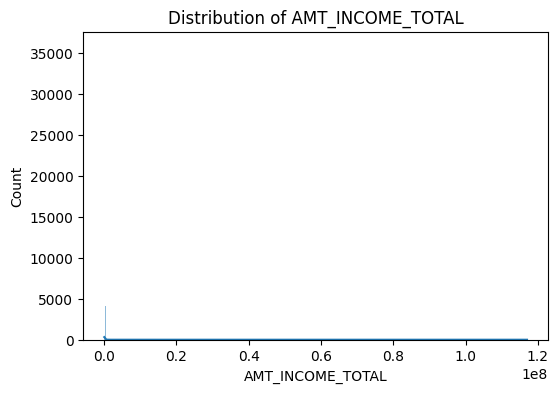

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(X["AMT_INCOME_TOTAL"], kde=True)
plt.title("Distribution of AMT_INCOME_TOTAL")
plt.show()


In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler

num_cols = X.select_dtypes(include=["number"]).columns

# Step 1: 先挑出高度偏態的欄位
high_skew = X[num_cols].skew().abs()
high_skew_cols = high_skew[high_skew > 5].index.tolist()   # 可調門檻
print("Highly skewed features:", len(high_skew_cols))

# Step 2: log1p 轉換這些欄位
for c in high_skew_cols:
    X[c] = np.log1p(np.clip(X[c], a_min=0, a_max=None))

# Step 3: 用 RobustScaler 處理最容易受 outlier 影響的金額類
robust_cols = [c for c in num_cols if ("AMT" in c) or ("SUM" in c) or ("RATIO" in c)]
robust_scaler = RobustScaler()
X[robust_cols] = robust_scaler.fit_transform(X[robust_cols])

# 其餘數值欄位仍用 StandardScaler
standard_cols = list(set(num_cols) - set(robust_cols))
scaler = StandardScaler()
X[standard_cols] = scaler.fit_transform(X[standard_cols])


Highly skewed features: 202


In [15]:
print("Mean (should ≈0):", X.mean().mean())
print("Std (should ≈1):", X.std().mean())


Mean (should ≈0): 0.10107313639889841
Std (should ≈1): 1.0548246194370616


In [9]:
# Diagnose missingness before PCA
import pandas as pd

df = pd.read_csv("train_merged.csv")
id_col = "SK_ID_CURR"
target_col = "TARGET"

num = df.select_dtypes(include=["number"]).drop(columns=[c for c in [id_col, target_col] if c in df.columns], errors="ignore")
miss_pct = num.isna().mean().sort_values(ascending=False)

print("Top 20 columns by missing rate:")
print((miss_pct*100).head(20).round(1).astype(str) + "%")

# (Optional) drop columns with too high missing rate, e.g., >80%
hi_miss_cols = miss_pct[miss_pct > 0.80].index.tolist()
print("Dropping high-missing columns:", len(hi_miss_cols))
num = num.drop(columns=hi_miss_cols)


Top 20 columns by missing rate:
PREV_RATE_INTEREST_PRIMARY_max               98.5%
PREV_RATE_INTEREST_PRIMARY_mean              98.5%
PREV_RATE_INTEREST_PRIMARY_min               98.5%
PREV_RATE_INTEREST_PRIVILEGED_mean           98.5%
PREV_RATE_INTEREST_PRIVILEGED_max            98.5%
PREV_RATE_INTEREST_PRIVILEGED_min            98.5%
PREV_CC_AMT_PAYMENT_CURRENT_mean_mean        82.8%
PREV_CC_AMT_PAYMENT_CURRENT_max_max          82.8%
PREV_CC_AMT_PAYMENT_CURRENT_mean_max         82.8%
PREV_CC_AMT_PAYMENT_CURRENT_max_min          82.8%
PREV_CC_AMT_PAYMENT_CURRENT_min_min          82.8%
PREV_CC_AMT_PAYMENT_CURRENT_min_max          82.8%
PREV_CC_AMT_PAYMENT_CURRENT_min_mean         82.8%
PREV_CC_AMT_PAYMENT_CURRENT_max_mean         82.8%
PREV_CC_AMT_PAYMENT_CURRENT_mean_min         82.8%
PREV_CC_AMT_DRAWINGS_POS_CURRENT_mean_max    82.8%
PREV_CC_AMT_DRAWINGS_POS_CURRENT_mean_min    82.8%
PREV_CC_CNT_DRAWINGS_POS_CURRENT_min_mean    82.8%
PREV_CC_CNT_DRAWINGS_ATM_CURRENT_min_max     82.8%

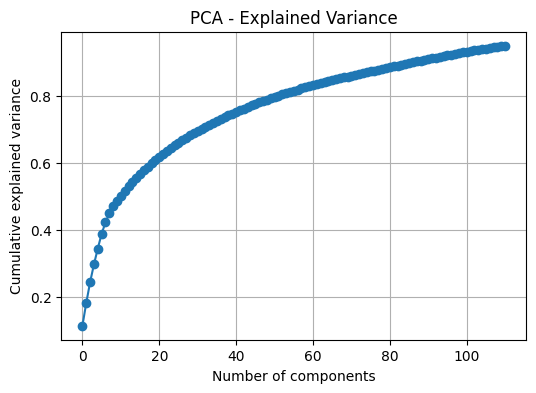

✅ PCA OK. Components for 95% variance: 111


In [10]:
# PCA pipeline with imputation + scaling
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# 1) impute numeric features with median (robust to skew/outliers)
imputer = SimpleImputer(strategy="median")
num_imputed = imputer.fit_transform(num)

# 2) (optional) log1p for heavy-tailed columns like amounts/ratios
#    You can skip this block if not needed.
cols = np.array(num.columns)
heavy_mask = np.array([("AMT" in c) or ("SUM" in c) or ("RATIO" in c) for c in cols])
X_heavy = num_imputed.copy()
X_heavy[:, heavy_mask] = np.log1p(np.clip(X_heavy[:, heavy_mask], a_min=0, a_max=None))

# 3) standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_heavy)

# 4) PCA keep 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 5) variance plot
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of components"); plt.ylabel("Cumulative explained variance")
plt.title("PCA - Explained Variance"); plt.grid(True); plt.show()

print(f"✅ PCA OK. Components for 95% variance: {pca.n_components_}")


Principal Component Analysis (PCA) was applied to the standardized numeric features to examine feature redundancy and identify the main sources of variance.
The cumulative explained variance curve shows that the first 111 components capture 95% of the total variance, indicating that many financial variables are correlated or redundant (e.g., loan amount, payment ratio, and income).
This suggests that the dataset contains strong underlying patterns representing customers’ financial behavior, such as credit utilization and repayment consistency.